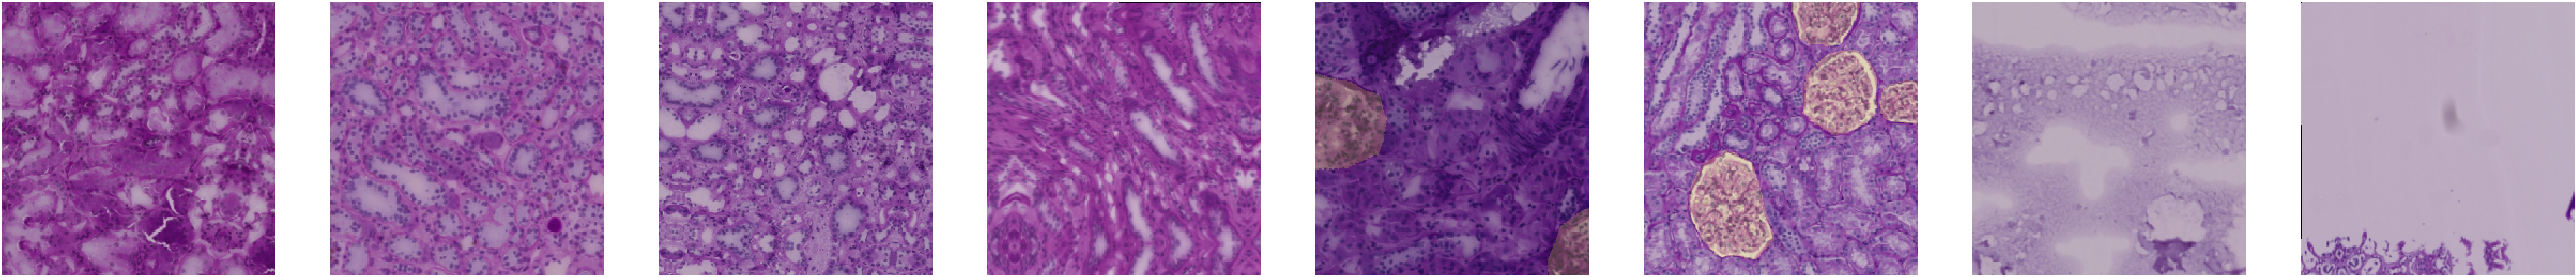

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import cv2
import random
import matplotlib.pyplot as plt

nfolds = 5
fold = 0
SEED = 2021
TRAIN = 'hubmap256/train/'
MASKS = 'hubmap256/masks/'
LABELS = 'input/train.csv'
NUM_WORKERS = 4

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True # brings some stochasticity, but 10% speed up

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, border_mode=cv2.BORDER_REFLECT),

    A.OneOf([
        A.CLAHE(clip_limit=2.0, p=0.5),
        A.HueSaturationValue(10, 15, 10, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ], p=0.5),

    A.OneOf([
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        A.GridDistortion(num_steps=3, distort_limit=0.5),
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.IAAPiecewiseAffine(p=0.5),
        A.IAASharpen(p=0.5),
        A.IAAEmboss(p=0.5),
    ], p=0.3),

    # A.Normalize(mean=(0.65459856, 0.48386562, 0.69428385), std=(0.15167958, 0.23584107, 0.13146145)),
    ToTensorV2(),
], p=1.0)

val_transforms = A.Compose([
    # A.Normalize(mean=(0.65459856, 0.48386562, 0.69428385), std=(0.15167958, 0.23584107, 0.13146145)),
    ToTensorV2(),
], p=1.0)

class HuBMAPDataset(Dataset):
    def __init__(self, ids, train=True, tfms=None):
        self.fnames = [fname for fname in os.listdir(TRAIN) if fname.split('_')[0] in ids]
        self.train = train
        self.tfms = tfms

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.cvtColor(cv2.imread(os.path.join(TRAIN, fname)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(MASKS, fname), cv2.IMREAD_GRAYSCALE)
        if self.tfms is not None:
            augmented = self.tfms(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']
        return img, mask

def prepare_dataloader(train_id, val_id):
    train_dataset = HuBMAPDataset(train_id, train=True, tfms=train_transforms)
    val_dataset = HuBMAPDataset(val_id, train=False, tfms=val_transforms)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=8)

    return train_loader, val_loader

def dataset_plt():
    seed_everything(2021)

    ids = pd.read_csv(LABELS).id.values
    folds = KFold(n_splits=nfolds, random_state=SEED, shuffle=True).split(ids)
    for fold, (train_idx, val_idx) in enumerate(folds):
        train_id, val_id = ids[train_idx], ids[val_idx]
        train_loader, val_loader = prepare_dataloader(train_id, val_id)
        dl = train_loader
        imgs, masks = next(iter(dl))

        plt.figure(figsize=(200, 200))
        for i, (img, mask) in enumerate(zip(imgs, masks)):
            img = img.permute(1,2,0).numpy().astype(np.uint8)
            plt.subplot(1, 8, i+1)
            plt.imshow(img, vmin=0, vmax=255)
            plt.imshow(mask.squeeze().numpy(), alpha=0.2)
            plt.axis('off')
            plt.subplots_adjust(wspace=None, hspace=None)
        plt.show()
        break

dataset_plt()

In [9]:
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np

nfolds = 8
SEED = 9419
# LABELS = '../input/train.csv'
# ids = pd.read_csv(LABELS).id.values
ids = np.array(['2f6ecfcdf', '8242609fa', 'aaa6a05cc', 'cb2d976f4', 'b9a3865fc',
       'b2dc8411c', '0486052bb', 'e79de561c', '095bf7a1f', '54f2eec69',
       '4ef6695ce', '26dc41664', 'c68fe75ea', 'afa5e8098', '1e2425f28'],
      dtype=object)
folds = KFold(n_splits=nfolds, random_state=SEED, shuffle=True).split(ids)
list(folds)

[(array([ 0,  1,  2,  3,  4,  6,  8,  9, 10, 11, 12, 13, 14]), array([5, 7])),
 (array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 12, 13, 14]),
  array([ 4, 11])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7, 10, 11, 12, 13, 14]), array([8, 9])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 13, 14]),
  array([10, 12])),
 (array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
  array([ 1, 14])),
 (array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14]),
  array([ 2, 13])),
 (array([ 0,  1,  2,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14]), array([3, 6])),
 (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([0]))]

In [10]:
ids

array(['2f6ecfcdf', '8242609fa', 'aaa6a05cc', 'cb2d976f4', 'b9a3865fc',
       'b2dc8411c', '0486052bb', 'e79de561c', '095bf7a1f', '54f2eec69',
       '4ef6695ce', '26dc41664', 'c68fe75ea', 'afa5e8098', '1e2425f28'],
      dtype=object)